In [1]:
from Functions import *
import scipy.interpolate as interpolate
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/optimization/


In [4]:
def define_Telescope(E0, m1_p=185.0, m2_p=175.5):
    z_s = 650
    
    ## Telescope
    m1 = optics.CurvedMirror('M1', p=m1_p, q=-58, length=1, z=185+z_s, alpha=2.65e-3)
    im_after_T1 = optics.PPM('im_after_T1', z=m1.z+.01, FOV=5e-3, N=256)
    
    m2 = optics.CurvedMirror('M2', p=m2_p, q=1e5, length=1, z=300+z_s, alpha=2.65e-3, orientation=2)
    im_after_T2 = optics.PPM('im_after_T2', z=m2.z+.01, FOV=5e-3, N=256)

    Telescope_devices = [m1, im_after_T1, m2, im_after_T2]

    return Telescope_devices

def define_HHLM_2DCM(
    E0, hkl1 = [1,1,1], alphaAsym1 = 9.0, hkl2 = [1,1,1], alphaAsym2 = 0.0, shapeErrors=[None for i in range(6)]):
    '''
    defines the HHLM optics for the 2DCM setup (1-1-2-2)
    E0: photon energy [eV]
    hkl: crystal reflection surface indices for pair 1 and pair 2
    alphaAsym: asymmetry angle [degree], negative value means beam footprint increases after reflection
    shapeErrors: crytal shapeError as loaded from Lin's profiles

    returns optics
    '''
    z_s = 650
    
    ## HHLM
    asym1 = np.deg2rad(alphaAsym1)
    asym2 = np.deg2rad(alphaAsym2)
    hhlm1 = optics.Crystal('HHLM1', hkl=[1,1,1], length=1e-1, width=5e-3, z=305+z_s, alphaAsym=-asym1, E0=E0, 
                           orientation=0, pol='s', shapeError=shapeErrors[0])
    im_after_HHLM1 = optics.PPM('im_after_HHLM1', FOV=20e-3,N=256,z=hhlm1.z+.01)

    hhlm2 = optics.Crystal('HHLM2', hkl=[1,1,1], length=1e-1, width=5e-3, z=hhlm1.z+139e-3, alphaAsym=asym1, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[3])
    im_after_HHLM2 = optics.PPM('im_after_HHLM2', FOV=20e-3,N=256,z=hhlm2.z+.01)

    hhlm3 = optics.Crystal('HHLM3', hkl=[1,1,1], length=1e-1, width=5e-3, z=hhlm1.z+361e-3, alphaAsym=-asym2, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[1])
    im_after_HHLM3 = optics.PPM('im_after_HHLM3', FOV=20e-3,N=256,z=hhlm3.z+.01)

    hhlm4 = optics.Crystal('HHLM4', hkl=[1,1,1], length=1e-1, width=5e-3, z=hhlm1.z+.5, alphaAsym=asym2, E0=E0,
                           orientation=0, pol='s', shapeError=shapeErrors[2])
    im_after_HHLM4 = optics.PPM('im_after_HHLM4', FOV=20e-3,N=256,z=hhlm4.z+.01)

    HHLM_devices = [hhlm1, im_after_HHLM1, hhlm2, im_after_HHLM2, hhlm3, im_after_HHLM3, hhlm4, im_after_HHLM4]

    return HHLM_devices

def define_HHLM_Zigzag(
    E0, hkl1 = [1,1,1], alphaAsym1 = 9.0, hkl2 = [4,4,0], alphaAsym2 = 0.0, shapeErrors=[None for i in range(6)]):
    '''
    defines the HHLM optics for the zigzag setup (1-2-2-1)
    E0: photon energy [eV]
    hkl: crystal reflection surface indices for pair 1 and pair 2
    alphaAsym: asymmetry angle [degree], negative value means beam footprint increases after reflection
    shapeErrors: crytal shapeError as loaded from Lin's profiles

    returns optics
    '''
    z_s = 650

    ## HHLM
    asym1 = np.deg2rad(alphaAsym1)
    asym2 = np.deg2rad(alphaAsym2)
    hhlm1 = optics.Crystal('HHLM1', hkl=[1,1,1], length=1e-1, width=5e-3, z=305+z_s, alphaAsym=-asym1, E0=E0, 
                           orientation=0, pol='s', shapeError=shapeErrors[0])
    im_after_HHLM1 = optics.PPM('im_after_HHLM1', FOV=30e-3,N=256,z=hhlm1.z+.01)

    hhlm2 = optics.Crystal('HHLM2', hkl=[4,4,0], length=1e-1, width=5e-3, z=hhlm1.z+139e-3, alphaAsym=-asym2, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[1])
    im_after_HHLM2 = optics.PPM('im_after_HHLM2', FOV=30e-3,N=256,z=hhlm2.z+.01)

    hhlm3 = optics.Crystal('HHLM3', hkl=[4,4,0], length=1e-1, width=5e-3, z=hhlm1.z+361e-3, alphaAsym=asym2, E0=E0,
                           orientation=0, pol='s', shapeError=shapeErrors[2])
    im_after_HHLM3 = optics.PPM('im_after_HHLM3', FOV=30e-3,N=256,z=hhlm3.z+.01)

    hhlm4 = optics.Crystal('HHLM4', hkl=[1,1,1], length=1e-1, width=5e-3, z=hhlm1.z+.5, alphaAsym=asym1, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[3])
    im_after_HHLM4 = optics.PPM('im_after_HHLM4', FOV=20e-3,N=256,z=hhlm4.z+.01)

    HHLM_devices = [hhlm1, im_after_HHLM1, hhlm2, im_after_HHLM2, hhlm3, im_after_HHLM3, hhlm4, im_after_HHLM4]

    return HHLM_devices

In [5]:
def define_beamline(
    E0, m1_p=185.0, m2_p=175.5, HHLM_type='2DCM',
    hkl1 = [1,1,1], alphaAsym1 = 9.0, hkl2 = [1,1,1], alphaAsym2 = 0.0,
    shapeErrors=[None for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0, hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2, shapeErrors=shapeErrors)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0, hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2, shapeErrors=shapeErrors)
    
    all_devices = [im_input] + Telescope_devices + HHLM_devices
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return mono_beamline


### Setup beamline

In [6]:
##### perfect case
m1_p = 185.0; m2_p = 175.5
HHLM_type = '2DCM'
hkl1 = [1,1,1]; alphaAsym1 = 9.0
hkl2 = [1,1,1]; alphaAsym2 = 9.0

dir_plot = dir_case+'{}_{}_{}'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[0],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[0]); make_dir(dir_plot)

path exists


### M2_p optimization

In [7]:
%%capture capt
n_loop = 31
m2_p = np.linspace(150, 200, n_loop)
pulse_duration = np.zeros_like(m2_p)
pulse_tilt = np.zeros_like(m2_p)
spatial_chirp = np.zeros_like(m2_p)
energy_bandwidth = np.zeros_like(m2_p)

for i in range(n_loop):
    mono_beamline = define_beamline(E0, m1_p=m1_p, m2_p=m2_p[i], HHLM_type=HHLM_type,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1, hkl2=hkl2, alphaAsym2=alphaAsym2)

    screen_names = ['im_input','im_after_HHLM4']
    
    beam_params['photonEnergy'] = E0
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=5000e-3, N=100)
    pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
    c, pulse_duration[i] = pulse.pulse_duration('im_after_HHLM4')
    pulse_tilt[i] = pulse.pulsefront_tilt('im_after_HHLM4')
    spatial_chirp[i] = pulse.spatial_chirp('im_after_HHLM4')
    energy_bandwidth[i] = pulse.pulse_bandwidth('im_after_HHLM4')


(0.0, 10.0)

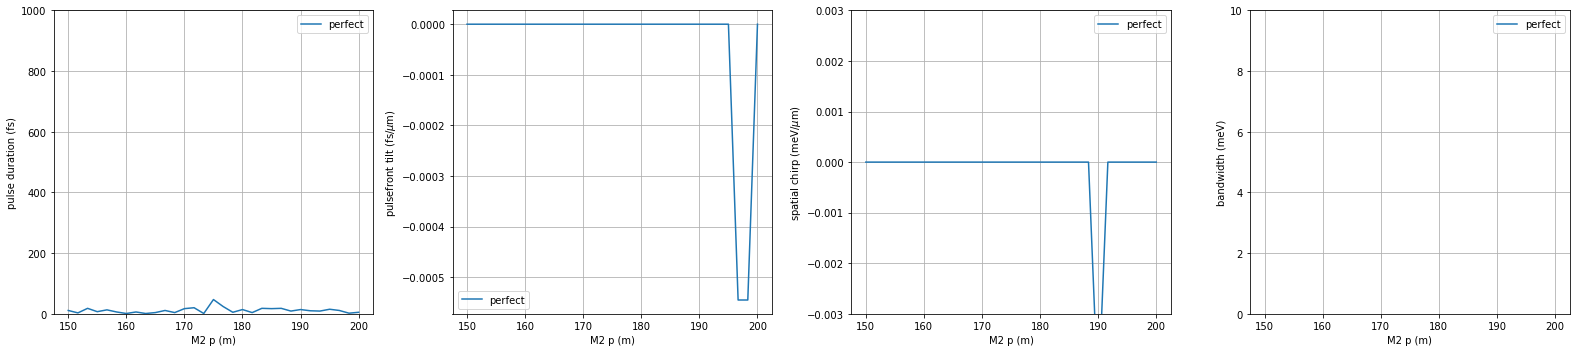

In [11]:
##### plots
# index = np.where(spatial_chirp>0)[0][-1]    # spatial chirp
# # index = energy_bandwidth.argmin()    # minimum bandwidth
# result = (m2_p[index] + m2_p[index+1])/2
# print('M2_p optimized: {}'.format(result))

plt.figure(figsize=(22,5))
# plt.suptitle('M2_p = {}'.format(result))

plt.subplot(1,4,1)
plt.plot(m2_p, pulse_duration,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 1e3])

plt.subplot(1,4,2)
plt.plot(m2_p, pulse_tilt,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(m2_p, spatial_chirp*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([-3e-3, 3e-3])

plt.subplot(1,4,4)
plt.plot(m2_p, energy_bandwidth*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([0, 10])

# plt.savefig(dir_plot+'M2_p_optimization.png')

In [ ]:
import winsound
winsound.Beep(1500, 3000)